# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  1
  ⋮
 -1
 -1
 -1
 -1
  1
 -1
 -1
  1
 -1

### We create a function to visualize the data

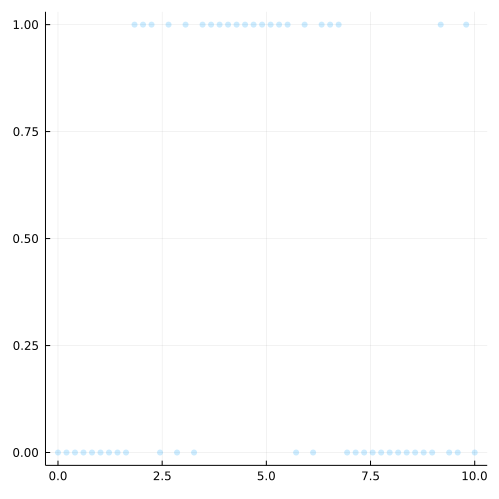

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.026817 seconds (1.82 M allocations: 103.808 MiB, 99.43% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.455997863421604, 1.5271593144288302, 1.5603310093118044, 1.5433207586966118, 1.470837899704101, 1.346268871841268, 1.1821390952474584, 0.9992627876579047, 0.8248010159631408, 0.6885674382732577  …  1.623391303625279, 1.5843515500521157, 1.4979829203291588, 1.3784165565555233, 1.2422207621413204, 1.1063923467013128, 0.987084491518622, 0.8969209359337995, 0.8432352488878192, 0.8256413979287158], θ = [0.2135441286865561, 0.2105807198551636, 0.2091869248148406, 0.20990254006747872, 0.21292945287580775, 0.2180240300371083, 0.22445091431766598, 0.23108396715144397, 0.23672923205647844, 0.24056927662129246  …  0.2065197099464622, 0.20817344547143796, 0.21180044103301326, 0.21672445130686036, 0.2221427478123829, 0.22727554334426914, 0.2315016316467247, 0.23448704878341836, 0.23616915831887736

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:11
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:08
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:05
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:33
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:14
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:02
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:46
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-1.2045582640705141, -1.509731036629088, -1.7449216986632086, -1.832997562725963, -1.8487408238081502, -1.7464268056085597, -1.5529906457684342, -1.272239476735271, -0.9313918270289491, -0.5618357219919695  …  -2.2836689829325167, -2.4100133957240515, -2.4174184499920277, -2.3779695857689127, -2.2345747323482494, -1.9985890167346776, -1.6312495657128485, -1.1076350798789414, -0.47222377644917746, 0.2357243976422395]]
 [[-1.769768571610085, -1.9652915058696707, -2.106563275095542, -2.1431031222369445, -2.0233613444093215, -1.8440532133212004, -1.5522508845335568, -1.2448990756280023, -0.9849400736002019, -0.7858193780333169  …  -2.3105925897599198, -2.1979717130397707, -2.018302754460903, -1.686575967916451, -1.3034034198596773, -0.8918785684427155, -0.5040359256608014, -0.13522175549508203, 0.1767631616071615, 0.41571412072423664]]
 [[-0.9705859475092847, -1.5259891044855158, -1.9477697811553445, -2.1782387453903187, -2.2100532594468913,

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

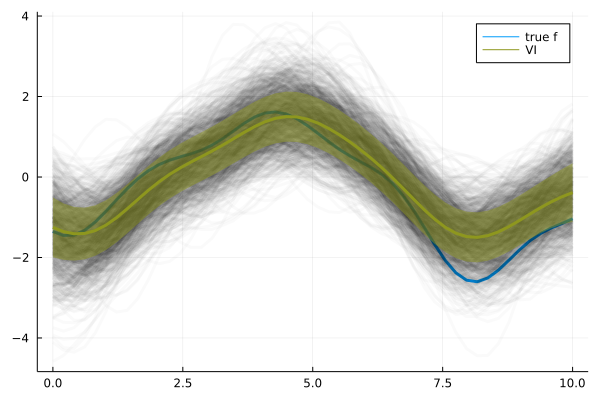

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

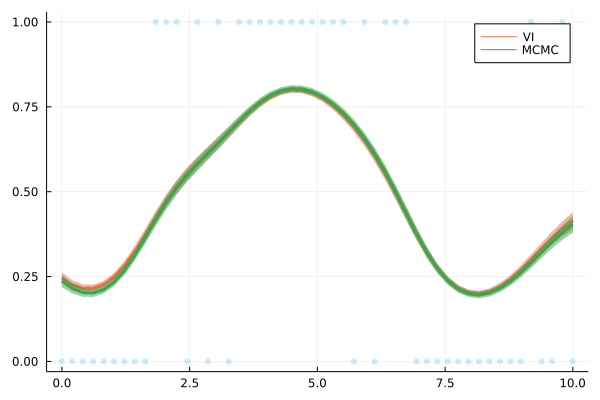

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*